In [1]:
import os
import pickle
import time
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import defaultdict
from numba import jit

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists
from power_planner.utils.utils_ksp import KspUtils

In [25]:
with open("../data/de_data_1_2.dat", "rb") as infile:
    (instance, edge_instance, instance_corr, config) = pickle.load(infile)

In [27]:
config.graph.pylon_dist_max = 12.5
config.graph.pylon_dist_min = 7.5

In [28]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitLG
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

    
tic1 = time.time()
graph = GRAPH_TYPE(
    instance, instance_corr
)

graph.set_shift(config.graph.start_inds, config.graph.dest_inds, **vars(config.graph))

graph.set_edge_costs(**vars(config.graph))
#     data.layer_classes, data.class_weights, angle_weight= 0.1 # cfg.ANGLE_WEIGHT
# )
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
print("1) set cost rest")

graph type: <class 'power_planner.graphs.implicit_lg.ImplicitLG'>
cost weights [0.16666667 0.83333333]
instance shape (1862, 1539)
time topo sort: 0.414
stack length 374944
memory taken (dists shape): 58491264
1) set cost rest


In [29]:
start_inds = config.graph.start_inds
dest_inds = config.graph.dest_inds

### Run one time to see best path

In [30]:
# compute first one
# modify dest inds because they are the highest one
graph.instance[tuple(dest_inds)] = graph.instance[tuple(start_inds)]
# compute path
graph.add_edges()
path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
c = [graph.instance[i,j] for (i,j) in path]
print(np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum)
PREV_MAX = np.max(c)

# initialize the collections
path_collection = [path]
std_maxmin_max = [[np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum]]

time edges: 44.279
0.06972204210484158 0.38184438040345825 0.4178674351585015 23.962018579303614


### Run in loop to get the variants

In [31]:
while True:
    print("current max:", PREV_MAX)
    graph.add_nodes()
    # set the once above the previous maximum point to inf
    graph.instance[graph.instance>=PREV_MAX] = np.inf
    graph.instance[tuple(dest_inds)] = graph.instance[tuple(start_inds)]
    graph.add_edges()
    try:
        path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
    except RuntimeWarning:
        print("already empty", PREV_MAX)
        break
    if len(path)==0:
        print("already empty", PREV_MAX)
        break
    # collect result
    path_collection.append(path)
    c = [graph.instance[i,j] for (i,j) in path]
    print(np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum)
    std_maxmin_max.append([np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum])
    PREV_MAX = np.max(c)

current max: 0.4178674351585015
time topo sort: 0.49
stack length 374944
memory taken (dists shape): 58491264
time edges: 41.979
0.06931358504134238 0.3638328530259366 0.39985590778097985 23.962673808685246
current max: 0.39985590778097985
time topo sort: 0.34
stack length 359174
memory taken (dists shape): 56031144
time edges: 39.64
0.0691128849649161 0.36263208453410184 0.3986551392891451 23.98584515075979
current max: 0.3986551392891451
time topo sort: 0.391
stack length 356386
memory taken (dists shape): 55596216
time edges: 41.886
0.06558526938438268 0.32901056676272816 0.3650336215177714 24.247430224087342
current max: 0.3650336215177714
time topo sort: 0.332
stack length 355938
memory taken (dists shape): 55526328
time edges: 45.118
0.06749949053306406 0.32300672430355426 0.3590297790585975 24.354075268316343
current max: 0.3590297790585975
time topo sort: 0.358
stack length 346911
memory taken (dists shape): 54118116
time edges: 41.117
0.0679361913779496 0.30979827089337175 0.3

In [32]:
# add means:
for p in range(len(std_maxmin_max)):
    path_len = len(path_collection[p])
    m = std_maxmin_max[p][3] / path_len
    std_maxmin_max[p].append(m)

In [34]:
np.save("variance_de.npy", std_maxmin_max)

In [35]:
plt.rcParams.update({'font.size': 15})

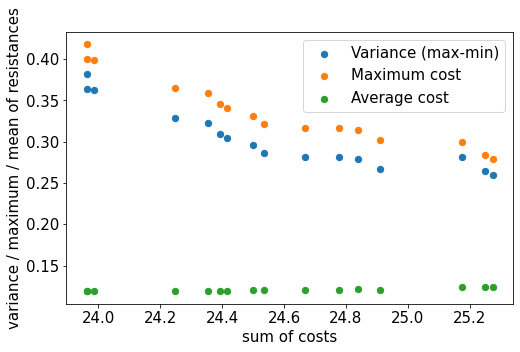

In [39]:
std_maxmin_max_2 = np.asarray(std_maxmin_max).copy()
plt.figure(figsize=(8,5))
# plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,0], label="standard deviation")
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,1], label="Variance (max-min)", s=40)
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,2], label="Maximum cost", s=40)
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,4], label="Average cost", s=40)
plt.legend()
plt.xlabel("sum of costs")
plt.ylabel("variance / maximum / mean of resistances")
# plt.title("Variance-cost tradeoff")
plt.savefig("../../figure/variance.png")
plt.show()

### Plot the paths

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(graph.instance)
for i,path in enumerate(path_collection[-4:]):
    path = np.asarray(path)
    plt.plot(path[:,1], path[:,0], linewidth=3, label=i )# str(round(std_maxmin_max_2[i, 2],2)))
plt.legend()
plt.colorbar()
plt.show()

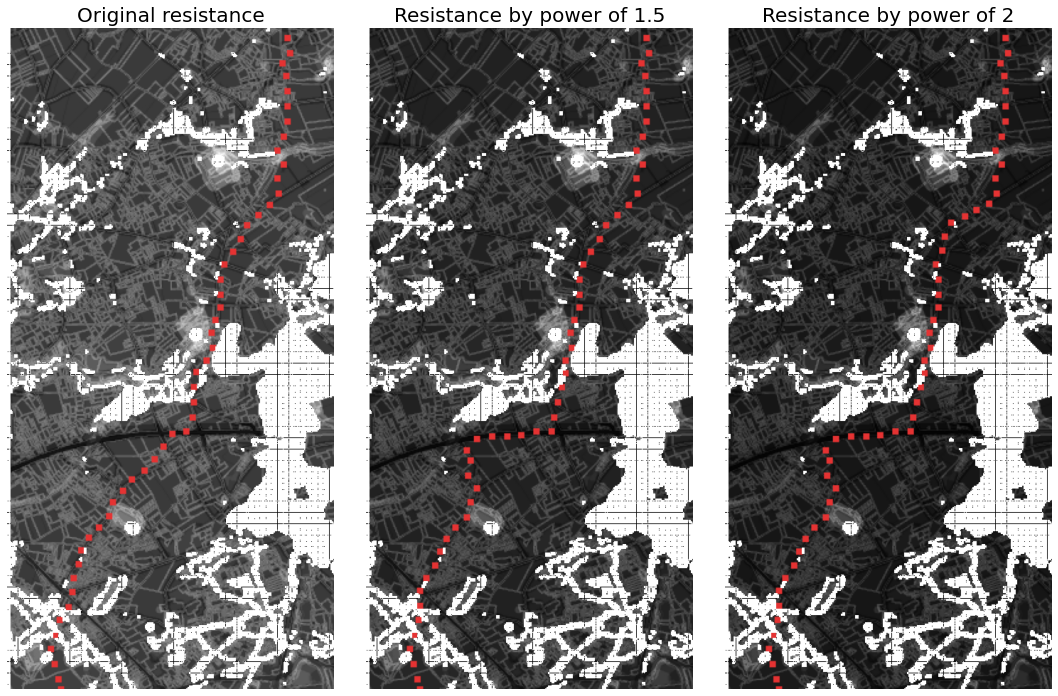

In [61]:
base = "../../outputs/power analysis/"
img = plt.imread(os.path.join(base, "power_analysis_belgium_1.0.png"))
plt.figure(figsize=(15,11))
plt.subplot(1,3,1)
plt.imshow(img[120:1050, 140:600])
plt.axis("off")
plt.title("Original resistance", fontsize=20)
img = plt.imread(os.path.join(base, "power_analysis_belgium_1.6.png"))
plt.subplot(1,3,2)
plt.imshow(img[120:1050, 140:600])
plt.axis("off")
plt.title("Resistance by power of "+str(1.5), fontsize=20)
img = plt.imread(os.path.join(base, "power_analysis_belgium_2.0.png"))
plt.subplot(1,3,3)
plt.imshow(img[120:1050, 140:600])
plt.axis("off")
plt.title("Resistance by power of "+str(2), fontsize=20)
plt.tight_layout()
plt.savefig("../../figure/power_resistance.pdf")
plt.show()

### Vary edge weight

In [ ]:
path_collection = []
labels = []
for e_w in [0.01, 0.1,0.3, 0.5, 0.7, 1]:
    graph.add_nodes()
    # set the once above the previous maximum point to inf
    graph.add_edges(edge_weight=e_w)
    try:
        path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
    except RuntimeWarning:
        print("already empty", PREV_MAX)
        break
    # collect result
    path_collection.append(path)
    print(cost_sum)
    e_cost = (cost_sum - np.dot(graph.cost_weights, np.sum(np.array(path_costs), axis=0))) / e_w
    print(e_cost)
    c = [graph.instance[i,j] for (i,j) in path]
    print(np.sum(c))
    labels.append(f"edge weight: {e_w}, edge costs: {e_cost}, all costs: {cost_sum}")

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(graph.instance)
for i,path in enumerate(path_collection):
    path = np.asarray(path)
    plt.plot(path[:,1], path[:,0], linewidth=3, label=str(round(std_maxmin_max_2[i, 2],2))) # labels[i])# 
plt.legend(fontsize=15)
plt.colorbar()
plt.show()

## Implement angle selection algorithm

In [ ]:
# test data
test_range = 200
for acd in [1, 5, 10, 15, 20, 30]:
    iterations = []
    for _ in range(100):
        test_c = (np.random.rand(test_range)*100).astype(int)
        c_tuples = [(c,i,0) for i,c in enumerate(test_c)]
        sorted_c = sorted(c_tuples, key = lambda x: x[0])

        # auxiliary lists
        e_update = [i for i in range(len(test_c))]
        to_update = np.ones(len(test_c))

        # queue
        q = []
        acd = 5
        update_counter = 1
        while np.any(to_update):
            # print(q)
            # print(sorted_c)
            # print(to_update)
            # print("------------")
            if len(q)>0 and q[0][0]< sorted_c[0][0]:
                cost, ind, div = q[0]
                del q[0]
            else:
                cost, ind, div = sorted_c[0]
                del sorted_c[0]
            # update step
            try:
                to_update[ind+div] = 0
                to_update[ind-div] = 0
            except IndexError:
                continue

            q.append((cost + acd, ind, div+1))
            update_counter+=1
        iterations.append(update_counter)
    print(np.mean(iterations), np.max(iterations)/test_range)

In [ ]:
# test data
def greedy(test_c, acd):
    best_ones = []
    for i in range(len(test_c)):
        helper = [val + abs(j-i)*acd for j,val in enumerate(test_c)]
        pred = np.argmin(helper)
        best_ones.append(pred)
    return np.asarray(best_ones)

test_range = 200
for acd in [10, 15, 20, 30]:
    iterations = []
    for _ in range(50):
        test_c = (np.random.rand(test_range)*100).astype(int)
        c_tuples = [(c,i,0) for i,c in enumerate(test_c)]
        sorted_c = sorted(c_tuples, key = lambda x: x[0])

        # auxiliary lists
        e_update = [i for i in range(len(test_c))]
        to_update = np.ones(len(test_c))
        
        # compute greedy method for validation
        preds_gt = greedy(test_c, acd)
        
        # queueb
        q = []
        update_counter = 1
        predecessor = np.zeros(len(test_c))
        while np.any(to_update):
            # print(q)
            # print(sorted_c)
            # print(to_update)
            # print("------------")
            
            # get next lowest value
            if len(q)>0 and q[0][0]< sorted_c[0][0]:
                cost, ind, div = q[0]
                del q[0]
            else:
                cost, ind, div = sorted_c[0]
                del sorted_c[0]
                
            # update step - only update if not updated yet!
            if to_update[ind+div]:
                # update
                updated_ind = ind+div
                predecessor[ind+div] = ind
                to_update[ind+div] = 0

                # CORRECTNESS: compare to ground truthpredecessor
                div_gt_pred = abs(preds_gt[updated_ind]-updated_ind)
                # if not equal predecessor and it does matter (not exactly equal costs)
                if ind != preds_gt[updated_ind] and cost!=abs(div_gt_pred)*acd+test_c[preds_gt[updated_ind]]:
                    print(test_c)
                    print(preds_gt[ind+div], ind, div, test_c[updated_ind-4:updated_ind+4], cost)
                
                # get in which direction to go further
                add = np.sign(div)
                if add==0:
                    # update -1: if in bounds and not updated yet
                    if ind-1>=0 and to_update[ind-1]:
                        q.append((cost + acd, ind, -1))
                    add = 1
                if ind+div+add >= 0 and ind+div+add < len(to_update) and to_update[ind+div+add]:
                    q.append((cost + acd, ind, div+add))
                # to_update[ind-div] = 0

            update_counter+=1
        iterations.append(update_counter)
        
        # print(predecessor)
        # print(preds_gt)
        # assert np.all(predecessor==preds_gt)
    print(np.mean(iterations), np.max(iterations)/test_range)

### Algorithm to be implemented in my framework:

### What guarantees

much better than 100 times 100, but not simply times 2 or so

In [ ]:
100 * np.log(100)